# Scanpy Single-Cell RNA-seq testing on GPU of ICT-HPC server

## Install packages

## Import requirements

In [1]:
import scanpy as sc
import anndata
#
import numpy as np
import pandas as pd
#
import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.8.0 umap==0.5.1 numpy==1.21.2 scipy==1.6.0 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.13.0 python-igraph==0.9.9 pynndescent==0.5.4


## Input data & load data

In [4]:
%%time
#Input files
adata = sc.read_10x_mtx(
    './data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.rea

... reading from cache file cache/data-matrix.h5ad
CPU times: user 391 ms, sys: 68.9 ms, total: 460 ms
Wall time: 459 ms


## Prepare Data

In [5]:
%%time
genes = cudf.Series(adata.var_names)
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 2.35 s, sys: 1.16 s, total: 3.51 s
Wall time: 4.32 s


In [6]:
sparse_gpu_array.shape

(3033, 36601)

In [7]:
sparse_gpu_array.nnz

4348611

In [8]:
sparse_gpu_array

## Preprocessing

### Filtering

In [9]:
%%time

sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=200, max_genes=3000)
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=3)

#sparse_gpu_array.var['mt'] = sparse_gpu_array.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
#sc.pp.calculate_qc_metrics(sparse_gpu_array, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#sparse_gpu_array = sparse_gpu_array[sparse_gpu_array.obs.pct_counts_mt < 20, :]

CPU times: user 308 ms, sys: 39.2 ms, total: 347 ms
Wall time: 347 ms


In [10]:
#sc.pl.highest_expr_genes(sparse_gpu_array, n_top=20, )

#sc.pl.violin(sparse_gpu_array, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)

#sc.pl.scatter(sparse_gpu_array, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(sparse_gpu_array, x='total_counts', y='n_genes_by_counts')

## Normalization & Scaling the data

In [11]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 8.83 ms, sys: 4.31 ms, total: 13.1 ms
Wall time: 13.1 ms


## Select Most Variable Genes

In [12]:
%%time
markers = ['CD8A', 'CD8B', 'IL7R', 'CCR7', 'CST7', 'KLRB1', 
                'S100A4', 'CD14', 'LYZ', 'LGALS3', 'S100A8', 
                'MS4A1','CD79A', #, 'GNLY', 'NKG7'
                'FCGR3A', 'MS4A7', 'PPBP', 'FCER1A', 'CST3'] # Marker genes for visualization


tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm


hvg = rapids_scanpy_funcs.highly_variable_genes(sparse_gpu_array, genes, n_top_genes=5000)



sparse_gpu_array = sparse_gpu_array[:, hvg]
genes = genes[hvg].reset_index(drop=True)
sparse_gpu_array.shape

CPU times: user 1.3 s, sys: 174 ms, total: 1.47 s
Wall time: 1.6 s


(2936, 5000)

In [13]:
#sc.pl.highly_variable_genes(sparse_gpu_array)

## Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
mito_genes = genes.str.startswith("MT-")

In [15]:
%%time
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()



sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_mito)

CPU times: user 1min 10s, sys: 42.7 s, total: 1min 53s
Wall time: 2min 38s


### Scale data

In [16]:
%%time
sparse_gpu_array = cp.clip(StandardScaler().fit_transform(sparse_gpu_array), a_min = -10, a_max=10)

CPU times: user 132 ms, sys: 118 ms, total: 250 ms
Wall time: 255 ms


## Perform linear dimensional reduction

In [17]:
%%time

adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()

for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

    
    
adata.obsm["X_pca"] = PCA(n_components=50, output_type="numpy").fit_transform(adata.X)

CPU times: user 570 ms, sys: 196 ms, total: 766 ms
Wall time: 771 ms


## Clustering

In [18]:
%%time
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15, method='rapids')


adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata, resolution=0.3)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
CPU times: user 6.37 s, sys: 9.9 s, total: 16.3 s
Wall time: 14.2 s


## Run non-linear dimensional reduction (UMAP)

In [19]:
%%time
sc.tl.umap(adata, min_dist=0.5, spread=1.0, method='rapids')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
CPU times: user 57.1 ms, sys: 716 ms, total: 773 ms
Wall time: 786 ms


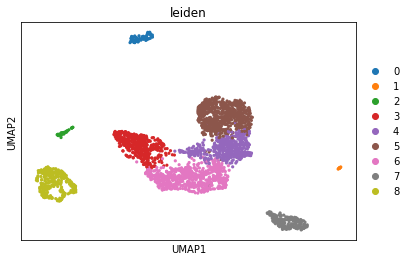

CPU times: user 352 ms, sys: 4.11 ms, total: 356 ms
Wall time: 358 ms


In [20]:
%%time
sc.pl.umap(adata, color=["leiden"])

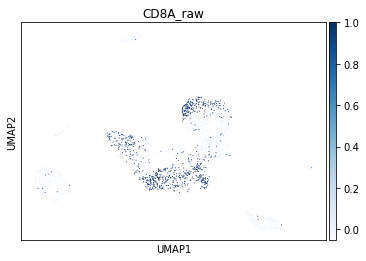

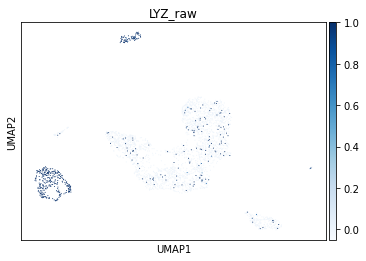

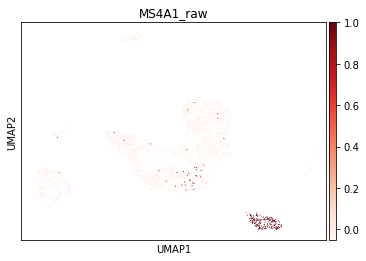

CPU times: user 643 ms, sys: 553 ms, total: 1.2 s
Wall time: 807 ms


In [21]:
%%time
sc.pl.umap(adata, size=4,color=["CD8A_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["LYZ_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["MS4A1_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Finding marker genes & ## Differential expression analysis

In [22]:
%%time
cluster_labels = cudf.Series.from_categorical(adata.obs["leiden"].cat)
genes = cudf.Series(genes)


scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    sparse_gpu_array, 
    cluster_labels, 
    genes, 
    n_genes=20, groups='all', reference='rest')

CPU times: user 557 ms, sys: 17.7 ms, total: 575 ms
Wall time: 744 ms


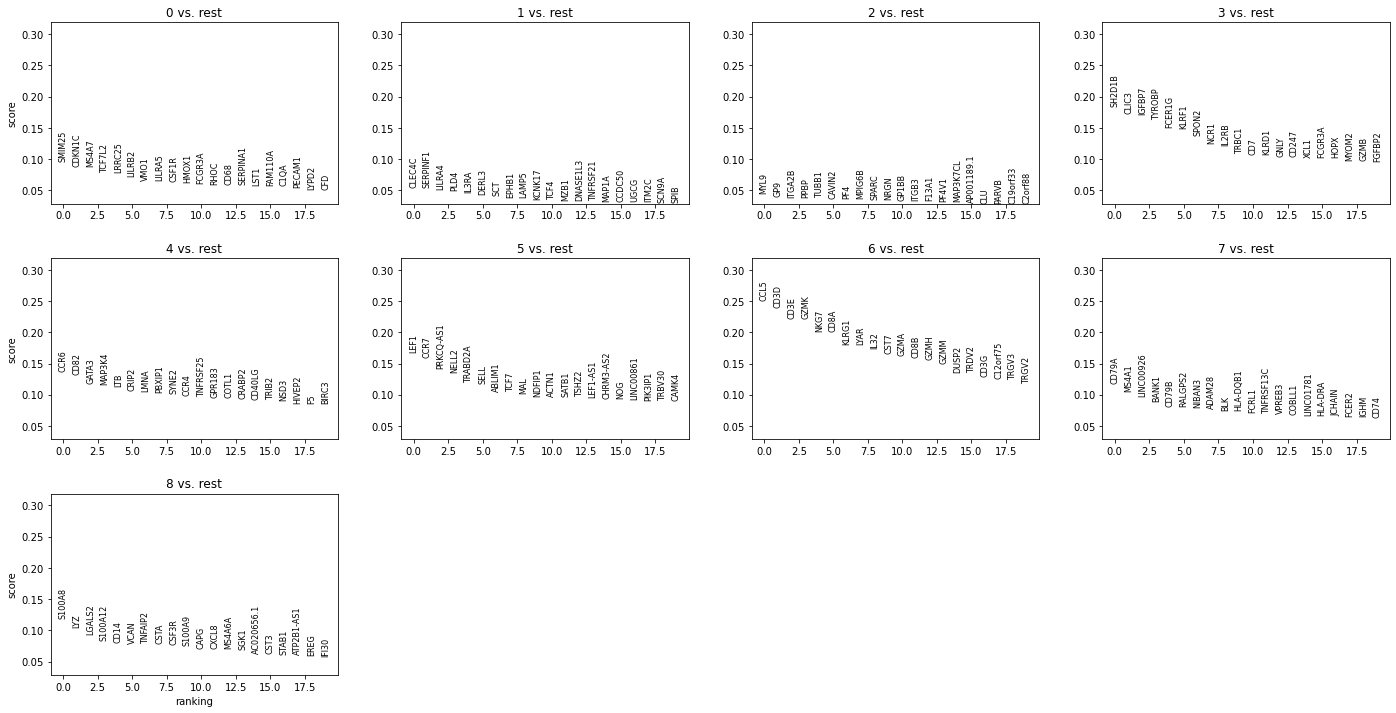

CPU times: user 2.07 s, sys: 267 ms, total: 2.33 s
Wall time: 2.22 s


In [23]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="leiden", method="wilcoxon", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

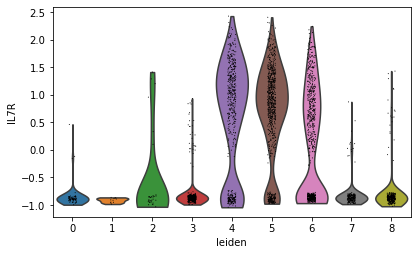

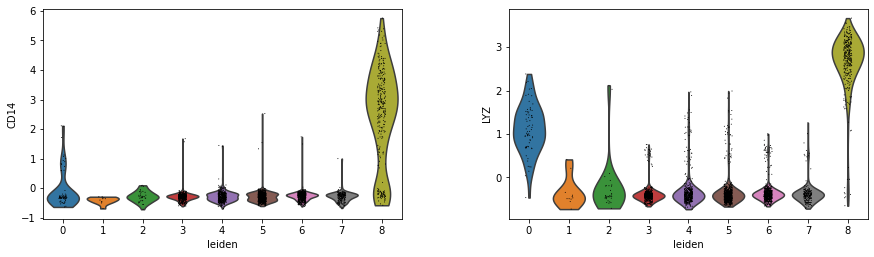

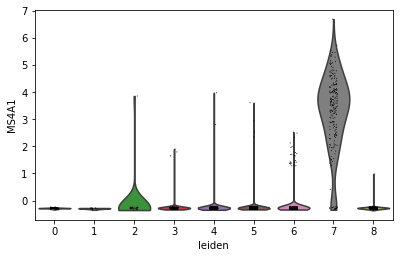

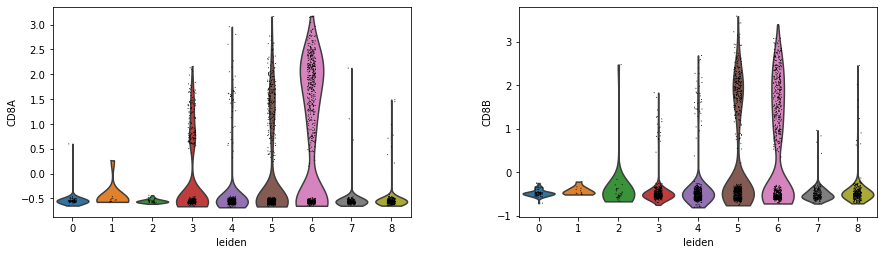

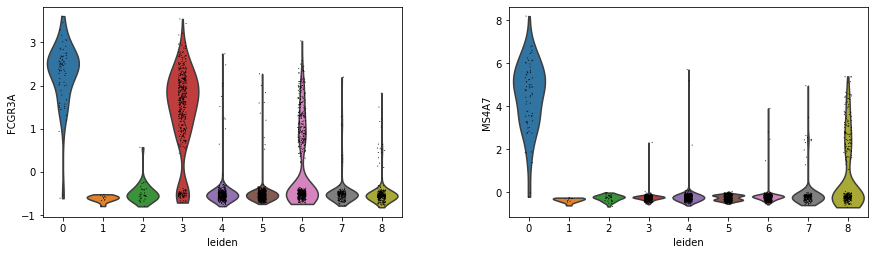

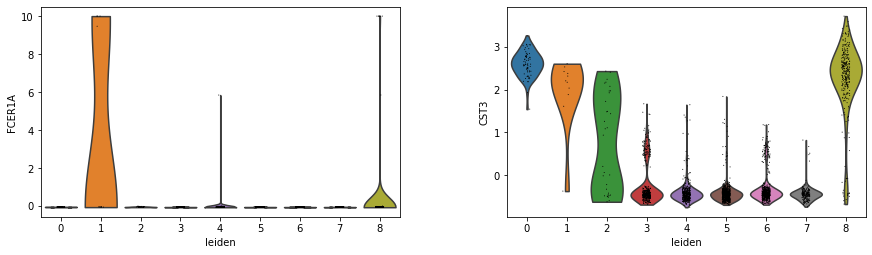

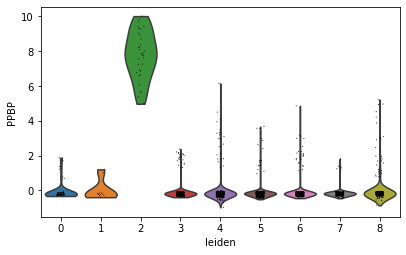

In [24]:
#CD4 T cells
sc.pl.violin(adata, ['IL7R'], groupby='leiden')
#CD14+ Monocytes
sc.pl.violin(adata, ['CD14', 'LYZ'], groupby='leiden')
#B cells
sc.pl.violin(adata, ['MS4A1'], groupby='leiden')
#CD8 T cells
sc.pl.violin(adata, ['CD8A', 'CD8B'], groupby='leiden')
#NK cells
#sc.pl.violin(adata, ['GNLY', 'NKG7'], groupby='leiden')
#FCGR3A+ Monocytes
sc.pl.violin(adata, ['FCGR3A', 'MS4A7'], groupby='leiden')
#Dendritic Cells
sc.pl.violin(adata, ['FCER1A', 'CST3'], groupby='leiden')
#Megakaryocytes
sc.pl.violin(adata, ['PPBP'], groupby='leiden')

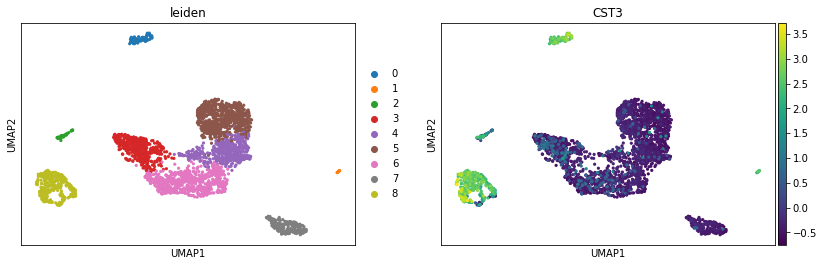

In [25]:
sc.pl.umap(adata, color=['leiden', 'CST3'])

## Cell type identification

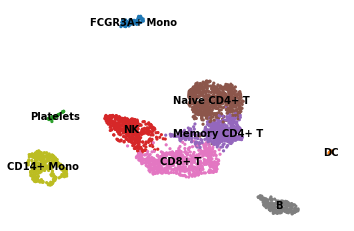

CPU times: user 661 ms, sys: 2.83 ms, total: 664 ms
Wall time: 665 ms


In [26]:
%%time
#Cell type identification
new_cluster_names = [
    'FCGR3A+ Mono', #0
    'DC', #1
    'Platelets', #2 
    'NK',
    'Memory CD4+ T', #4
    'Naive CD4+ T', #5
    'CD8+ T',  #6
    'B', #7
    'CD14+ Mono'] #8
#adata.rename_categories('leiden', new_cluster_names)
adata.obs['leiden'] =adata.obs['leiden'].cat.rename_categories(new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

## Visualization (dot plot & violin plot)

In [27]:
marker_genes = ['CD8A', 'CD8B', 'IL7R', 'CCR7', 'CST7', 'KLRB1', 
                'S100A4', 'CD14', 'LYZ', 'LGALS3', 'S100A8', 
                'MS4A1','CD79A', #, 'GNLY', 'NKG7'
                'FCGR3A', 'MS4A7', 'PPBP', 'FCER1A', 'CST3']

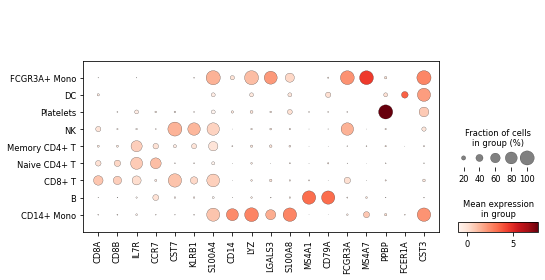

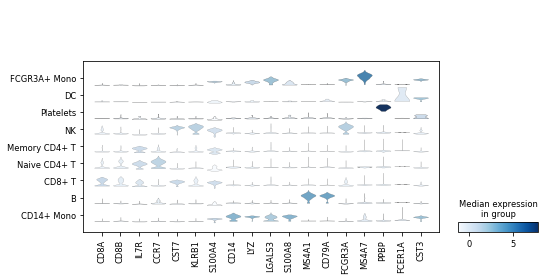

CPU times: user 2.91 s, sys: 340 ms, total: 3.25 s
Wall time: 3.06 s


In [28]:
%%time
#Visualization
#Dot plot
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
#Violin plot
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

## Save file

In [29]:
results_file = './write/GPU_HPC_test_AIDA_Pilot_RAPIDs.h5ad'

In [30]:
%%time
#Save file
adata.write(results_file)

CPU times: user 87 ms, sys: 104 ms, total: 191 ms
Wall time: 193 ms
